# Naive Bayes (NB) Classifier  

# Objective  
In this colab, we will implement Naive Bayes (NB) classifier from scratch.  

## Learning problem  
* _**k**_ prior probabilities to be estimated: **{p(y1), p(y2), .... , p(yk)}**  
* _**k x m**_ class conditional probabilities: **{p(x1|y1),...,p(xm|y1), p(x1|y2),...,p(xm|y2), ......, p(x1|yk), ...,p(xm|yk)}**  

The class conditional densities depend on the nature of features.  

In [3]:
import numpy as np 

# Bernoulli NB: implementation  

While estimating parameters of the model, we process examples from each label separately and estimate the parameters.  

In [4]:
def fit(X, y):
  n_samples, n_features = X.shape
  class_count = np.unique(y)
  n_classes = len(class_count)

  # Initialize the weight vectors.  
  w = np.zeros((n_classes, n_features), dtype=np.float64)
  w_priors = np.zeros(n_classes, dtype=np.float64)

  for c in range(n_classes):  # processing examples from each class separately.
    # get examples with label = c
    X_c = X[y == c]

    # estimation of w_{jy_c}: The parameter of Bernoulli distribution
    # p(x_j|y_c) ~ Ber(w_{jy_c})
    # We have vectorized this operation and we obtain vector w_{y_c} that
    # contains w_{jy_c} for each x_j.
    w[c, :] = np.sum(X_c, axis=0)/X_c.shape[0]

    # estimation of prior probability: w_{y_c}
    w_priors[c] = X_c.shape[0]/float(n_samples)

  print(f"Weight vector: {w}")
  print(f"Priors: {w_priors}")
  return w, w_priors

Let's look at the parameter estimation in step by step manner:  


In [5]:
# feature matrix with shape (4, 2). x_1 ~ Ber(w_1), x_2 ~ Ber(w_2)
X = np.array([[1, 0], [0, 1], [0, 1], [1, 0]])

# label vector with shape (4,)
y = np.array([1, 0, 0, 1])

# call fit with feature matrix and label vector as arguments.  
fit(X, y)

# Returns parameters of Bernoulli distribution and priors. 

Weight vector: [[0. 1.]
 [1. 0.]]
Priors: [0.5 0.5]


(array([[0., 1.],
        [1., 0.]]), array([0.5, 0.5]))

Watch [video](https://youtu.be/agAkNbLY7Ck?t=915) for explanation.  

Let's understand the class conditional density calculation step by step:  

STEP 1: Filter examples for a class, say c = 1

In [6]:
X_c = X[y == 1]
X_c

array([[1, 0],
       [1, 0]])

STEP 2: Feature wise sum.

In [7]:
np.sum(X_c, axis=0)

array([2, 0])

STEP 3: Dividing by the class count.

In [8]:
w = np.sum(X_c, axis=0)/X_c.shape[0]
w

array([1., 0.])

## Incorporating Laplace correction  

As we talked in the lecture slides, the 0 value for parameter is a problem as it leads to 0 posterior probability. We can fix this problem with **Laplace correction** or by adding a small counts in each class for each feature.  

See the calculation of **class priors** and **class conditional density** in lecture video.  

[Video link](https://youtu.be/agAkNbLY7Ck?t=1100)

## Inference  

### Determine class label  

[Video link](https://youtu.be/agAkNbLY7Ck?t=1153)  

* *Note down the vectorized formula for Bernoulli NB (not given in lecture slides)*  

## Implementation  

In [9]:
class BernoulliNB(object):
  def __init__(self, alpha=1.0):    # alpha is for smoothing/correction. When it is 1.0, it is called Laplace smoothing.
    self.alpha = alpha

  def fit(self, X, y):
    n_samples, n_features = X.shape
    class_count = np.unique(y)
    n_classes = len(class_count)

    self.w = np.zeros((n_classes, n_features), dtype=np.float64)
    self.w_priors = np.zeros(n_classes, dtype=np.float64)

    for c in range(n_classes):
      X_c = X[y == c]
      self.w[c, :] = (np.sum(X_c, axis=0) + self.alpha)/(X_c.shape[0] + 2 * self.alpha)
      self.w_priors[c] = (X_c.shape[0] + self.alpha)/(float(n_samples) + n_classes * self.alpha)

    print(f"Class conditional density: {self.w}")
    print(f"Prior: {self.w_priors}")

  def log_likelihood_prior_prod(self, X):
    return X@(np.log(self.w).T) + (1-X)@np.log((1-self.w).T) + np.log(self.w_priors)

  def predict_proba(self, X):
    q = self.log_likelihood_prior_prod(X)
    return np.exp(q)/np.expand_dims(np.sum(np.exp(q), axis=1), axis=1)
    # np.exp is used to change values from log space back into the original space

  def predict(self, X):
    return np.argmax(self.log_likelihood_prior_prod(X), axis=1)
    # np.argmax gives us the index of the largest value in an array

## Demo  

## Binary classification set up  

In [10]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X, y)

Class conditional density: [[0.25 0.75]
 [0.75 0.25]]
Prior: [0.5 0.5]


*Note that this is the result after Laplace correction/smoothing.*  
*When we did the same thing in the beginning without Laplace smoothing (before we implemented the BernoulliNB class), we got different values of class conditional densities.*  

In [11]:
# Let's predict classes for input example.
bernoulli_nb.predict(X)

array([1, 0, 0, 1])

In [12]:
# The class labels are inferred by selecting the label that results into
# highest value of product of likelihood and priors:
bernoulli_nb.log_likelihood_prior_prod(X)

array([[-3.4657359 , -1.26851133],
       [-1.26851133, -3.4657359 ],
       [-1.26851133, -3.4657359 ],
       [-3.4657359 , -1.26851133]])

Observe that based on this calculation, the first example gets class 1, second one gets class 0, third also gets class 0 and the last one gets class 1.  

In [13]:
# Let's predict probabilities for each example
bernoulli_nb.predict_proba(X)

array([[0.1, 0.9],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9]])

## Multiclass classification set up  

The NB implementation also works in multiclass setting. Here is an example with three classes.  

In [14]:
X = np.array([[1,0], [0,1], [0,1], [1,0], [1,1], [1,1]])
y = np.array([1, 0, 0, 1, 2, 2])

Estimation of parameters of Bernoulli distribution and class priors.

In [15]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X, y)

Class conditional density: [[0.25 0.75]
 [0.75 0.25]
 [0.75 0.75]]
Prior: [0.33333333 0.33333333 0.33333333]


In [16]:
# Let's predict classes for input example.
bernoulli_nb.predict(X)

array([1, 0, 0, 1, 2, 2])

In [17]:
# Let's predict probabilities for each example.
bernoulli_nb.predict_proba(X)

array([[0.07692308, 0.69230769, 0.23076923],
       [0.69230769, 0.07692308, 0.23076923],
       [0.69230769, 0.07692308, 0.23076923],
       [0.07692308, 0.69230769, 0.23076923],
       [0.2       , 0.2       , 0.6       ],
       [0.2       , 0.2       , 0.6       ]])

## Gaussian NB: Implementation  

### Parametrization  
### Alternate parametrization through multivariate Gaussian  
### Parameter estimation  
### Inference  

For all these parts, watch the [lecture video](https://youtu.be/7DHeQCggj34)!

## Implementation  

In [18]:
class GaussianNB(object):
    def fit(self, X, y):
        '''parameter estimation for Gaussian distribution'''
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class.
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
          # Get examples with label c
          X_c = X[y == c]

          # estimate mean from the training examples of class c
          self._mean[idx, :] = X_c.mean(axis=0)

          # estimate variance from the training examples of class c
          self._var[idx, :] = X_c.var(axis=0)

          # estimate the priors - based on fraction of examples with labels c
          # among all training examples.
          self._priors[idx] = X_c.shape[0] / float(n_samples)

        print(f"Mean: {self._mean}")
        print(f"Variance: {self._var}")
        print(f"Priors: {self._priors}")

    def _calc_pdf(self, class_idx, X):
          '''calculates probability density for samples for class label class_idx.'''
          mean = self._mean[class_idx]
          var = np.diag(self._var[class_idx])
          z = np.power(2 * np.pi, X.shape[0]/2) * np.power(np.linalg.det(var), 1/2)
          return (1/z) * np.exp(-(1/2)*(X - mean).T@(np.linalg.inv(var))@(X - mean))

    def _calc_prod_likelihood_prior(self, X):
          '''calculates product of likelihood and priors.'''
          self._prod_likelihood_prior = np.zeros((X.shape[0], len(self._classes)),
                                                dtype=np.float64)
          for x_idx, x in enumerate(X):
            for idx, c in enumerate(self._classes):
              self._prod_likelihood_prior[x_idx, c] = (
                  np.log(self._calc_pdf(idx, x)) + np.log(self._priors[idx]))
            
    def predict(self, X):
          '''predicts class labels for each example.'''
          self._calc_prod_likelihood_prior(X)
          return np.argmax(self._prod_likelihood_prior, axis=1)

    def predict_proba(self, X):
          '''calculates probability of each example belonging to different classes.'''
          self._calc_prod_likelihood_prior(X)
          return np.exp(self._prod_likelihood_prior)/np.expand_dims(
              np.sum(np.exp(self._prod_likelihood_prior), axis=1), axis=1)

## Demo  

Watch [lecture video](https://youtu.be/7DHeQCggj34?t=704) to know the details of each step.  

STEP 1: Generate training data with two multivariate Gaussian distribution one with mean [5, 5] and the second one with mean [10, 10] and standard deviation of 1.5 for each Gaussian.  

* The total number of features per example = 2  
* Total number of examples = 100  

In [19]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split

# generate artificial data points
X, y = make_blobs(n_samples = 100,
                  n_features=2,
                  centers=[[5,5],[10,10]],
                  cluster_std=1.5,
                  random_state=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=123)

STEP 2: Train the naive bayes classifier.  

In [20]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)

Mean: [[ 4.55853975  5.01739665]
 [10.30431548 10.08580617]]
Variance: [[2.13298417 2.30222002]
 [3.22242307 2.20662074]]
Priors: [0.5125 0.4875]


STEP 3: Plot the gaussian distributions.  

Copy plot code from [lecture video](https://youtu.be/7DHeQCggj34?t=852)!

In [21]:
gaussian_nb.predict(X_test)

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0])

* Generate the classification report - containing information about different classification evaluation metrics like precision, recall, F1-score and accuracy.  

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, gaussian_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



* Let's get the probability of each example belonging to each class.  

In [23]:
gaussian_nb.predict_proba(X_test)

array([[9.99999746e-01, 2.54140753e-07],
       [7.63749214e-14, 1.00000000e+00],
       [4.23038642e-03, 9.95769614e-01],
       [9.99986614e-01, 1.33855473e-05],
       [7.05769182e-06, 9.99992942e-01],
       [9.99820566e-01, 1.79433743e-04],
       [9.72541524e-01, 2.74584756e-02],
       [9.99982043e-01, 1.79572091e-05],
       [2.85910189e-05, 9.99971409e-01],
       [1.01888837e-07, 9.99999898e-01],
       [7.39129058e-01, 2.60870942e-01],
       [9.99793438e-01, 2.06561658e-04],
       [9.99999915e-01, 8.46737165e-08],
       [2.03213294e-05, 9.99979679e-01],
       [8.76198350e-09, 9.99999991e-01],
       [6.51163513e-05, 9.99934884e-01],
       [9.27638525e-05, 9.99907236e-01],
       [7.58034673e-09, 9.99999992e-01],
       [1.81773339e-03, 9.98182267e-01],
       [9.99985544e-01, 1.44557945e-05]])

* Let's make a prediction for new data point.  

In [24]:
import matplotlib.pyplot as plt

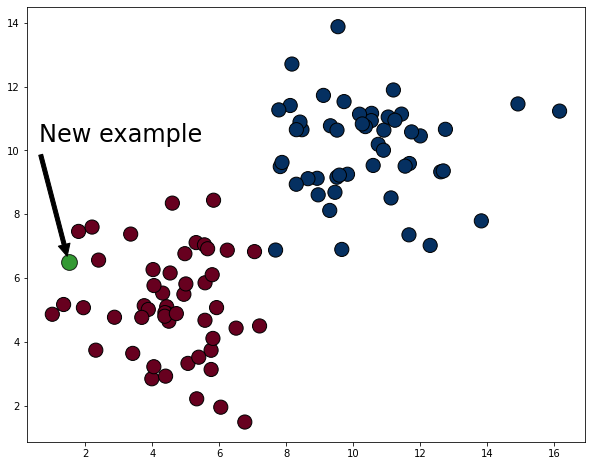

In [25]:
x_new = np.array([1.5, 6.5])

plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=200, edgecolor='k', cmap='RdBu')

plt.scatter(x_new[0], x_new[1], marker='o', c='green',
            s=250, edgecolor='k', alpha=0.8)
plt.annotate('New example', xy=x_new,
             xytext=(-30,120),textcoords='offset points',
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=24)
plt.show()

Since the data point is close to Gaussian distribution with mean [5,5], it will get label of that class.  

In [26]:
gaussian_nb.predict_proba(np.array([x_new]))

array([[9.99996296e-01, 3.70449944e-06]])

Observe that the probability of the new example belonging to class 0, which has mean of [5,5] is 0.99, which is much larger than the other class and hence it is assigned class label of 0.  

## Multiclass classification  

Watch [lecture video](https://youtu.be/7DHeQCggj34?t=1014) for steps.  

In [27]:
# generate synthetic dataset with three classes.  
# Each example is represented with two features.  
X, y = make_blobs(n_samples=100,
                  n_features=2,
                  centers=[[5,5],[10,10],[20,20]],
                  cluster_std=1.5,
                  random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=123)

Let's estimate the parameters of Gaussian distributions.  

In [28]:
gaussian_nb_multiclass = GaussianNB()
gaussian_nb_multiclass.fit(X_train, y_train)

Mean: [[ 4.94844927  4.67947138]
 [ 9.62097704 10.49990402]
 [19.63832097 19.94706375]]
Variance: [[1.99332345 2.36976247]
 [1.68415535 2.25596351]
 [1.79203315 1.24939267]]
Priors: [0.3375 0.35   0.3125]


Let's use the estimated parameters to make prediction on test examples and generate a classification evaluation report.  

In [29]:
print(classification_report(y_test, gaussian_nb_multiclass.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Finally predict probability of each text example belonging to three different classes.  

In [30]:
gaussian_nb_multiclass.predict_proba(X_test)

array([[1.02996770e-47, 2.67740135e-24, 1.00000000e+00],
       [5.00111567e-05, 9.99949989e-01, 6.51529293e-32],
       [9.99999999e-01, 9.45325297e-10, 1.33290144e-78],
       [1.00000000e+00, 6.49743430e-12, 7.70260328e-90],
       [1.50617094e-52, 5.94123831e-27, 1.00000000e+00],
       [3.77917160e-47, 9.99218112e-23, 1.00000000e+00],
       [5.30598294e-33, 9.05195020e-13, 1.00000000e+00],
       [6.63950534e-07, 9.99999336e-01, 1.42699786e-26],
       [3.57244754e-61, 3.86494439e-34, 1.00000000e+00],
       [9.70872284e-06, 9.99990291e-01, 5.02104511e-31],
       [9.99982252e-01, 1.77477098e-05, 2.51366893e-63],
       [3.93493321e-39, 5.51495730e-18, 1.00000000e+00],
       [1.00000000e+00, 4.72574372e-11, 1.19906531e-79],
       [1.19575291e-47, 3.45203067e-24, 1.00000000e+00],
       [9.09245241e-01, 9.07547595e-02, 1.30885257e-46],
       [9.99999997e-01, 2.64110663e-09, 3.37901343e-80],
       [9.97572472e-01, 2.42752753e-03, 1.17514148e-55],
       [1.12896485e-05, 9.99988

# Multinomial NB: Implementation  

We use multinomial naive Bayes classifier for problems like document classifier.  
See video for mathematical expressions, features, labels and parameters involved.

[Lecture video](https://youtu.be/EyqfNyty_wk)  

## Parameter estimation  
[video link](https://youtu.be/EyqfNyty_wk?t=139)  

## Inference  
[video link](https://youtu.be/EyqfNyty_wk?t=230)  

## Implementation  
[video link](https://youtu.be/EyqfNyty_wk?t=274)  

In [59]:
class MultinomialNB(object):
  def fit(self, X, y, alpha=1):   # alpha is for smoothing/correction. If alpha = 1, it is Laplace smoothing. 
    '''implements parameter estimation for multinomial NB.'''
    n_samples, n_features = X.shape
    self._classes = np.unique(y)
    n_classes = len(self._classes)

    # calculate parameters of k multinomial distributions and priors (k is the number of classes, k = n_classes here.)
    self.w = np.zeros((n_classes, n_features), dtype=np.float64)
    self.w_prior = np.zeros(n_classes, dtype=np.float64)

    for idx, c in enumerate(self._classes):
      # calculate for each class by working on the data belonging to that class.
      X_c = X[y == c]

      # get the total count of features for class c.
      total_count = np.sum(np.sum(X_c, axis=1))

      # estimate parameters of multinomia distribution of class c.
      self.w[idx, :] = (np.sum(X_c, axis=0) + alpha)/(
          total_count + alpha * n_features)
      
      # estimate class prior for class c.
      self.w_prior[idx] = (X_c.shape[0] + alpha) / float(
          n_samples + alpha * n_classes)
  
  def log_likelihood_prior_prod(self, X):
    '''calculates log of product of likelihood and prior.'''
    return X@(np.log(self.w).T) + np.log(self.w_prior)

  def predict(self, X):
    '''predicts class for input examples.'''
    return np.argmax(self.log_likelihood_prior_prod(X), axis=1)

  def predict_proba(self, X):
    '''calculates probability of examples belonging to different classes.'''
    q = self.log_likelihood_prior_prod(X)
    return np.exp(q)/np.expand_dims(np.sum(np.exp(q), axis=1), axis=1)

## Demo  
*Note: Our implemetation works for binary as well as multiclass settings.*  
[video link](https://youtu.be/EyqfNyty_wk?t=540)  

## Binary set up  

Generate synthetic data for two classes and each example with 5 features.  

In [54]:
rng = np.random.RandomState(1)
X = rng.randint(5, size=(1000, 5))
y = rng.randint(2, size=(1000,))

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [55]:
print(f"Shape of feature matrix: {X_train.shape}")
print(f"Shape of label vector: {y_train.shape}")

Shape of feature matrix: (750, 5)
Shape of label vector: (750,)


Estimate the parameters of multinomial NB.  

In [62]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train, y_train)

# Examine the parameters of multinomia NB.
print(f"Prior: {multinomial_nb.w_prior}")
print("Parameters of multinomial distribution:\n", multinomial_nb.w)

Prior: [0.47606383 0.52393617]
Parameters of multinomial distribution:
 [[0.21103987 0.19040981 0.19542793 0.19570672 0.20741567]
 [0.21129235 0.19849435 0.19146801 0.20050188 0.19824341]]


Observe that
* Each class is equally likely - each class has probability of 0.5
* Sum of probabilities of different features for each class = 1

Let's evaluate the classifier:  

In [63]:
print(classification_report(y_test, multinomial_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.53      0.18      0.27       128
           1       0.49      0.84      0.62       122

    accuracy                           0.50       250
   macro avg       0.51      0.51      0.44       250
weighted avg       0.51      0.50      0.44       250



The lower values of precision and recall is due to random label assignment in the synthetic data.  

Let's calculate the probability of each example belonging to both the classes:  

In [67]:
multinomial_nb.predict_proba(X_test[:5])
# we examine only the first five rows because there are 250 samples in test data.  

array([[0.49000634, 0.50999366],
       [0.46955065, 0.53044935],
       [0.49912806, 0.50087194],
       [0.42190988, 0.57809012],
       [0.48082264, 0.51917736]])

## Multiclass set up  

[Lecture video](https://youtu.be/EyqfNyty_wk?t=756)  

Let's generate data for 3 classes.  

In [68]:
rng = np.random.RandomState(1)
X = rng.randint(5, size=(1000, 5))
y = rng.randint(3, size=(1000,))

X_train, X_test, y_train, y_test = train_test_split(X, y)

Let's estimate parameters of multinomial naive Bayes classifier.  

In [69]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train, y_train)

# Examine the parameters of multinomia NB.
print(f"Prior: {multinomial_nb.w_prior}")
print("Parameters of multinomial distribution:\n", multinomial_nb.w)

Prior: [0.35325365 0.34794157 0.29880478]
Parameters of multinomial distribution:
 [[0.20757465 0.20138383 0.18099053 0.19664967 0.21340131]
 [0.21698842 0.18339768 0.2015444  0.2019305  0.196139  ]
 [0.21396396 0.20315315 0.19279279 0.19459459 0.1954955 ]]


Let's evaluate the classifier we have learnt:  

In [71]:
print(classification_report(y_test, multinomial_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.29      0.44      0.35        82
           1       0.31      0.46      0.37        81
           2       0.33      0.02      0.04        87

    accuracy                           0.30       250
   macro avg       0.31      0.31      0.25       250
weighted avg       0.31      0.30      0.25       250



The lower values of precision and recall is due to random label assignment in the synthetic data.  

Finally, predict probability for test examples belonging to differnet classes.  

In [73]:
multinomial_nb.predict_proba(X_test[:5])
# we examine only the first five rows because there are 250 samples in test data.  

array([[0.34850082, 0.34587661, 0.30562257],
       [0.36357228, 0.30825831, 0.32816941],
       [0.34891226, 0.34287218, 0.30821556],
       [0.32996825, 0.34192184, 0.32810991],
       [0.33711338, 0.37315358, 0.28973304]])

# =======================    THE END    =======================

# Rough work

In [38]:
a = np.diag((1,2,3)) + 5 + [2, 3, 4]
a

array([[ 8,  8,  9],
       [ 7, 10,  9],
       [ 7,  8, 12]])

In [37]:
b = np.sum(a, axis=0)
b

array([22, 26, 30])

In [39]:
c = np.sum(a, axis=1)
c

array([25, 26, 27])

In [43]:
tot = np.sum(a)
tot

78

In [47]:
np.zeros((10, 3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])